In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

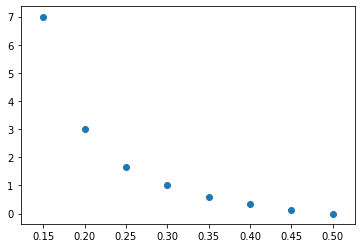

In [4]:
k = np.linspace(0.15,0.5,8)
plt.scatter(k, (0.5-k)/(k-0.1))

# Main object

## Deprecated version

In [ ]:
# 0.3
# This version works. Problem: Rt, no recovery incoperated, no asymp transmission, no environmental transmission

class Simulation:
    def __init__(self, initial_infection):
        self.day = 0
        self.n_infected = initial_infection
        self.type = np.random.choice(3, initial_infection, p=[0.05, 0.75, 0.2])
        self.infection_day = np.zeros(initial_infection).astype(int)
        self.onset = (np.random.weibull(a=2.04, size=self.n_infected) / 0.103).astype(int)
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100
            
        # symtom onset
        self.asymptomatic = (self.type == 0).astype(int)
        self.symptomatic = (self.onset <= self.day).astype(int)
        self.presymptomatic = (self.onset > self.day).astype(int) - self.asymptomatic
        self.history =np.array([(self.type==0).sum(), (self.type==1).sum(), (self.type==2).sum(), (self.type==3).sum()])
        
        
    def step(self, Rt=1, P_pcr=0.59, P_ct=0.88,D_s=3,D_m=5,TP_s=1,TP_m=0.3,TP_ct=0.05):
        self.reset()
        self.test(P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct)
        self.infect(Rt)
        self.update()
        self.record()
                
    def reset(self):
        self.day += 1
        self.new_infected = 0
        
    def test(self,P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct):
        #         severe got tested, and isolated
        for i in np.argwhere(np.logical_and(self.symptomatic, self.type==2)):
            if self.day >= self.onset[i] + D_s and np.random.random() < TP_s and np.random.random() < P_pcr:
                self.type[i] = 3

        #         part of mild got tested, and isolated
        if TP_m > 0:
            for i in np.argwhere(np.logical_and(self.symptomatic, self.type==1)):
                if self.day >= self.onset[i] + D_m and np.random.random() < TP_m and np.random.random() < P_pcr:
                    self.type[i] = 3
                
#         part of presymptomatic get tested
        if TP_ct > 0:
            for i in np.argwhere(self.presymptomatic ==1):
                 if np.random.random() < TP_ct and np.random.random() < P_ct:
                        self.type[i] = 3
                
                
    def infect(self, Rt):
        for i in range(self.n_infected):
            if int(self.day - self.infection_day[i]) <= 13 and self.type[i] in [1,2]:
                self.new_infected += Rt * beta_t[int(self.day - self.infection_day[i])]
        self.new_infected = int(round(self.new_infected))

        
    def update(self):
        self.n_infected += self.new_infected
        self.type = np.concatenate([self.type, 
                                    np.random.choice(3, self.new_infected, p=[0.05, 0.75, 0.2])])
        self.infection_day = np.concatenate([self.infection_day,
                                            np.ones(self.new_infected).astype(int) * self.day])
        self.onset = np.concatenate([self.onset,
                                     (np.random.weibull(a=2.04, size=self.new_infected) / 0.103).astype(int) + self.day
                                    ])
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100
        
        self.asymptomatic = (self.type == 0).astype(int)
        self.symptomatic = np.logical_and(self.onset <= self.day, self.type <= 2).astype(int)
        self.presymptomatic = (self.onset > self.day).astype(int) - self.asymptomatic
        
    def record(self):
        new_history = np.array([(self.type==0).sum(), (self.type==1).sum(), (self.type==2).sum(), (self.type==3).sum()])
        self.history = np.append(self.history, new_history, axis=0)

## Experimental version

In [ ]:
# new version, dynamics Rt, yet finished! Should use true infection for k rather than reported cases
R_T_MAX = 6
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*50+1)
GAMMA = 1/7

class Simulation:
    def __init__(self, initial_infection):
        self.day = 0
        self.n_infected = initial_infection
        self.type = np.random.choice(3, initial_infection, p=[0.05, 0.75, 0.2])
        self.infection_day = np.zeros(initial_infection).astype(int)
        self.onset = (np.random.weibull(a=2.04, size=self.n_infected) / 0.103).astype(int)
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100
        self.rt = 2
                    
        # symtom onset
        self.asymptomatic = (self.type == 0).astype(int)
        self.symptomatic = (self.onset <= self.day).astype(int)
        self.presymptomatic = (self.onset > self.day).astype(int) - self.asymptomatic
        self.history =np.array([(self.type==0).sum(), (self.type==1).sum(), (self.type==2).sum(), (self.type==3).sum()])
        
        
    def step(self, Rt=1, P_pcr=0.59, P_ct=0.88,D_s=3,D_m=5,TP_s=1,TP_m=0.3,TP_ct=0.05):
        self.reset()
        self.test(P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct)
        self.infect(Rt)
        self.update()
        self.record()
        if self.day > 7:
            self.calculate_Rt()
                
    def reset(self):
        self.day += 1
        self.new_infected = 0
        
    def test(self,P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct):
        #         severe got tested, and isolated
        for i in np.argwhere(np.logical_and(self.symptomatic, self.type==2)):
            if self.day >= self.onset[i] + D_s and np.random.random() < TP_s and np.random.random() < P_pcr:
                self.type[i] = 3
                
#         part of mild got tested, and isolated
        for i in np.argwhere(np.logical_and(self.symptomatic, self.type==1)):
            if self.day >= self.onset[i] + D_m and np.random.random() < TP_m and np.random.random() < P_pcr:
                self.type[i] = 3
                
#         part of presymptomatic get tested
#         for i in np.argwhere(self.presymptomatic ==1):
#              if np.random.random() < TP_ct and np.random.random() < P_ct:
#                     self.type[i] = 3
                
    def infect(self, Rt):
        for i in range(self.n_infected):
            if int(self.day - self.infection_day[i]) <= 13 and self.type[i] in [1,2]:
                self.new_infected += Rt * beta_t[int(self.day - self.infection_day[i])]
        self.new_infected = int(round(self.new_infected))

        
    def update(self):
        self.n_infected += self.new_infected
        self.type = np.concatenate([self.type, 
                                    np.random.choice(3, self.new_infected, p=[0.05, 0.75, 0.2])])
        self.infection_day = np.concatenate([self.infection_day,
                                            np.ones(self.new_infected).astype(int) * self.day])
        self.onset = np.concatenate([self.onset,
                                     (np.random.weibull(a=2.04, size=self.new_infected) / 0.103).astype(int) + self.day
                                    ])
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100
        
        self.asymptomatic = (self.type == 0).astype(int)
        self.symptomatic = np.logical_and(self.onset <= self.day, self.type <= 2).astype(int)
        self.presymptomatic = (self.onset > self.day).astype(int) - self.asymptomatic
        
    def record(self):
        new_history = np.array([(self.type==0).sum(), (self.type==1).sum(), (self.type==2).sum(), (self.type==3).sum()])
        self.history = np.append(self.history, new_history, axis=0)
        
    def calculate_Rt(self):
        k = np.array(pd.Series(self.history.reshape(-1,4).T[-1]).diff().fillna(0).clip(lower=1))[-7:]
        lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

        likelihood_r_t = sps.poisson.pmf(k[1:], lam)
        likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

        posteriors = likelihood_r_t.cumprod(axis=1)
        posteriors = posteriors / np.sum(posteriors, axis=0)

        columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
        posteriors = pd.DataFrame(data = posteriors, index = r_t_range, columns = columns)

        most_likely_values = posteriors.idxmax(axis=0)
        self.rt = most_likely_values.iloc[-1]
        print(self.day, self.rt)
       
    
# Run    
s = Simulation(500)

for day in range(7):
    s.step(Rt=1, D_s=2,D_m=5,TP_s=1,TP_m=0.3,TP_ct=0.05)

for day in range(30):
    s.step(Rt=s.rt, D_s=2,D_m=5,TP_s=1,TP_m=0.3,TP_ct=0.05)
    
focus = pd.DataFrame(s.history.reshape(-1,4), columns=['Asymptomatic','Presymptomatic','Symptomatic','Isolated'])
print(s.n_infected)
print(round(100*focus.iloc[-1,-1] / focus.iloc[-1].sum(),2),'% detected')

## Current working version

In [2]:
# 0.4

class Simulation:
    def __init__(self, initial_infection):
        self.day = 0
        self.n_infected = initial_infection
        self.new_infected = 0
        self.type = np.random.choice(3, initial_infection, p=[0.05, 0.75, 0.2])
        self.infection_day = np.zeros(initial_infection).astype(int)
#         self.infection_day = np.random.randint(low=-4, high=0, size=initial_infection)
        self.onset = (np.random.weibull(a=2.04, size=self.n_infected) / 0.103).astype(int)
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100            
        
        self.update()
        
        
    def step(self, Rt=1, P_pcr=0.59, P_ct=0.88,D_s=4,D_m=6,TP_s=1,TP_m=0.3,TP_ct=0.01):
        self.reset()
        self.test(P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct)
        self.infect(Rt)
        self.update()
                        
    def reset(self):
        self.day += 1
        self.new_infected = 0
        
    def test(self,P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct):
        for i in np.argwhere(np.logical_and(self.symptomatic, self.type==2)):
            if self.day >= self.onset[i] + D_s and np.random.random() < TP_s and np.random.random() < P_pcr:
                self.type[i] = 3

        if TP_m > 0:
            for i in np.argwhere(np.logical_and(self.symptomatic, self.type==1)):
                if self.day >= self.onset[i] + D_m and np.random.random() < TP_m and np.random.random() < P_pcr:
                    self.type[i] = 3
                
        if TP_ct > 0:
            for i in np.argwhere(self.presymptomatic==1):
                 if np.random.random() < TP_ct and np.random.random() < P_ct:
                        self.type[i] = 3
                
                
    def infect(self, Rt):
        for i in range(self.n_infected):
            if int(self.day - self.infection_day[i]) <= 13 and self.type[i] in [1,2]:
                self.new_infected += Rt * beta_t[int(self.day - self.infection_day[i])]
        self.new_infected = int(round(self.new_infected))

        
    def update(self):
        self.n_infected += self.new_infected
        self.type = np.concatenate([self.type, 
                                    np.random.choice(3, self.new_infected, p=[0.05, 0.75, 0.2])])
        self.infection_day = np.concatenate([self.infection_day,
                                            np.ones(self.new_infected).astype(int) * self.day])
        self.onset = np.concatenate([self.onset,
                                     (np.random.weibull(a=2.04, size=self.new_infected) / 0.103).astype(int) + self.day
                                    ])
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100
        
        self.isolated = (self.type == 3).astype(int)        
        self.asymptomatic = (self.type == 0).astype(int)
        self.symptomatic = np.logical_and(np.logical_or(self.type==1, self.type==2), self.onset<=self.day).astype(int)
        self.presymptomatic = np.logical_and(np.logical_or(self.type==1, self.type==2), self.onset>self.day).astype(int)
        
        new_history = np.array([
            self.asymptomatic.sum(),
            self.presymptomatic.sum(),
            self.symptomatic.sum(),
            self.isolated.sum()
        ])
                
        if self.day == 0:
            self.history = new_history
        else:
            self.history = np.append(self.history, new_history, axis=0)

# PCR test + CT scan

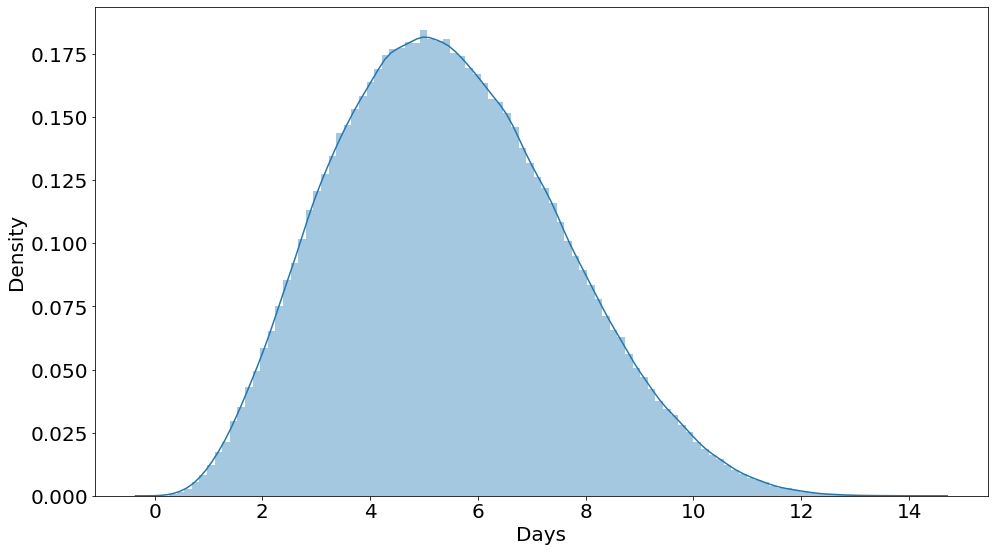

In [5]:
sample =np.random.beta(4, 7, size=500000) * 15
# sample = np.random.gamma(12, scale=.4, size=500000)

fig, ax = plt.subplots(figsize=(16,9))
ax.tick_params(labelsize=20)
ax.set_xlabel('Days', fontsize=20)
ax.set_ylabel('Density', fontsize=20)

sns.distplot(sample, ax=ax, bins=100)

beta_t = (np.histogram(sample, bins = range(15))[0] / len(sample))

In [552]:
# 0.5
# This version tries to add contact tracing

class Simulation:
    def __init__(self, initial_infection):
        self.day = 0
        self.n_infected = initial_infection
        self.new_infected = 0
        self.type = np.random.choice(3, initial_infection, p=[0.05, 0.75, 0.2])
        self.infection_day = np.zeros(initial_infection).astype(int)
#         self.infection_day = np.random.randint(low=-4, high=0, size=initial_infection)
        self.onset = (np.random.weibull(a=2.04, size=self.n_infected) / 0.103).astype(int)
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100            
        self.today_report = 0
        self.isolated = (self.type == 3).astype(int)        
        self.asymptomatic = (self.type == 0).astype(int)

        self.update(tracing_rate=1)
        
        
        
    def step(self, Rt=1, P_pcr=0.70, P_ct=0.95,D_s=4,D_m=4,TP_s=1,TP_m=0,TP_ct=0.01, tracing_rate=0.6):
        self.reset()
        self.test(P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct)
        self.infect(Rt)
        self.update(tracing_rate)
                        
    def reset(self):
        self.day += 1
        self.new_infected = 0
        self.today_report = 0
        
    def test(self,P_pcr,P_ct,D_s,D_m,TP_s,TP_m,TP_ct):
        for i in np.argwhere(np.logical_and(self.symptomatic, self.type==2)):
            if self.day >= self.onset[i] + D_s and np.random.random() < TP_s and np.random.random() < P_pcr:
                self.type[i] = 3
                self.today_report += 1
                

        if TP_m > 0:
            for i in np.argwhere(np.logical_and(self.symptomatic, self.type==1)):
                if self.day >= self.onset[i] + D_m and np.random.random() < TP_m and np.random.random() < P_pcr:
                    self.type[i] = 3
                    self.today_report += 1
                
        if TP_ct > 0:
            for i in np.argwhere(self.presymptomatic==1):
                 if np.random.random() < TP_ct and np.random.random() < P_ct:
                        self.type[i] = 3
                        self.today_report += 1
                        
        for i in np.argwhere(self.traced==1):
            if self.day >= self.onset[i]:
                self.type[i] = 3
                
                
    def infect(self, Rt):
        for i in range(self.n_infected):
            if int(self.day - self.infection_day[i]) <= 13 and self.type[i] in [1,2]:
                self.new_infected += Rt * beta_t[int(self.day - self.infection_day[i])]
        self.new_infected = int(round(self.new_infected))

        
    def update(self, tracing_rate=0.6):
        # now omit asymptomatic
        detection_rate = self.today_report / max(self.today_report,
                                                 (self.n_infected - self.isolated.sum() - self.asymptomatic.sum())
                                                )
        #         print(detection_rate)
        self.n_infected += self.new_infected
        self.type = np.concatenate([self.type, 
                                    np.random.choice(3, self.new_infected, p=[0.05, 0.75, 0.2])])
        
        for i in np.argwhere(np.logical_or(self.type==1, self.type==2)):
            if np.random.random() < detection_rate * tracing_rate:
                self.type[i] = 4
        
        self.infection_day = np.concatenate([self.infection_day,
                                            np.ones(self.new_infected).astype(int) * self.day])
        self.onset = np.concatenate([self.onset,
                                     (np.random.weibull(a=2.04, size=self.new_infected) / 0.103).astype(int) + self.day
                                    ])
        for i in np.argwhere(self.type==0):
            self.onset[i] = self.day + 100
        
        self.isolated = (self.type == 3).astype(int)        
        self.asymptomatic = (self.type == 0).astype(int)
        self.symptomatic = np.logical_and(np.logical_or(self.type==1, self.type==2), self.onset<=self.day).astype(int)
        self.presymptomatic = np.logical_and(np.logical_or(self.type==1, self.type==2), self.onset>self.day).astype(int)
        self.traced = (self.type == 4).astype(int)
        
        new_history = np.array([
            self.asymptomatic.sum(),
            self.presymptomatic.sum(),
            self.symptomatic.sum(),
            self.isolated.sum(),
            self.traced.sum()
        ])
                
        if self.day == 0:
            self.history = new_history
        else:
            self.history = np.append(self.history, new_history, axis=0)

Rt = 1.25 for different regimes
Rt = 1.07 for strategy 1 to be flat

In [584]:
s = Simulation(1000)

for day in range(20):
    s.step(Rt=1.25,
           D_s=4,
           D_m=4,
           TP_m=0,
           TP_ct=0)
#     print(s.)

import copy
initial = copy.copy(s)

In [410]:
s = copy.copy(initial)
    
for day in range(60):
    s.step(Rt=1.25,
           D_s=1,
           D_m=1,
           TP_m=1,
           TP_ct=0,
          tracing_rate=0)
    print(day)
    
focus = pd.DataFrame(s.history.reshape(-1,5), columns=['Asymptomatic','Presymptomatic','Symptomatic','Isolated positive','Isolated traced'])
print(s.n_infected)
# print(round(100*focus.iloc[-1,-1] / focus.iloc[-1].sum(),2),'% detected')

# plt.plot(focus.sum(axis=1).diff().iloc[14:].reset_index(drop=True))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
190018


In [411]:
sc6 = focus.copy()

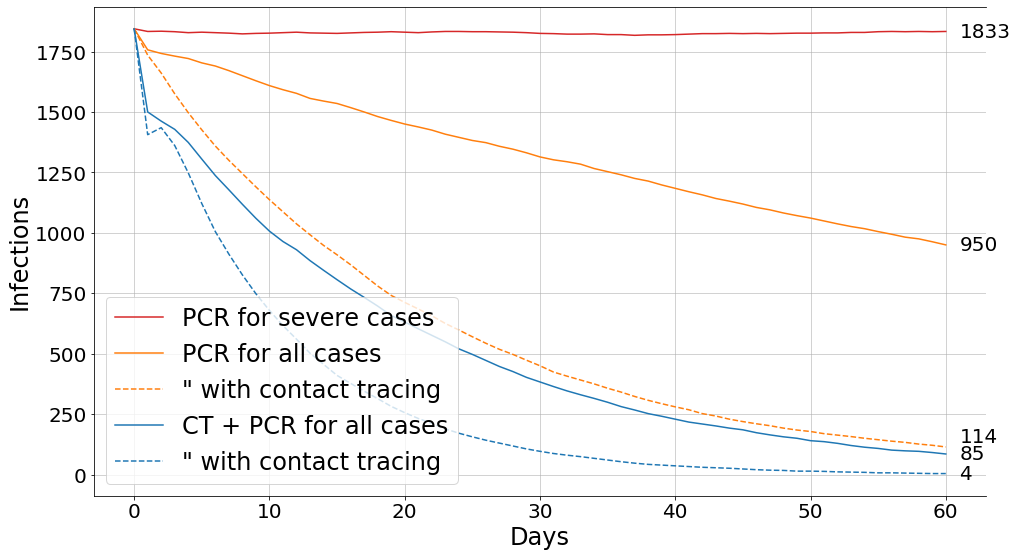

In [391]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(sc4.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C3', label='PCR for severe cases')

ax.plot(sc5.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C1', label='PCR for all cases')
ax.plot(sc5a.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')

ax.plot(sc6.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C0', label='CT + PCR for all cases')
ax.plot(sc6a.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for sc in [sc4,sc5,sc6,sc6a]:
    ax.annotate(int(sc.sum(axis=1).diff().values[-1]),
                xy=(len(sc)-20,sc.sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)
    
ax.annotate(int(sc5a.sum(axis=1).diff().values[-1]),
                xy=(len(sc)-20,sc5a.sum(axis=1).diff().values[-1]+40),va='center',ha='left',fontsize=20)

# ax.set_yscale('log')

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc='lower left', fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
# plt.tight_layout()
ax.spines['right'].set_visible(False)
plt.savefig('figures/for paper/3 tesintg settings_3.png', dpi=600)

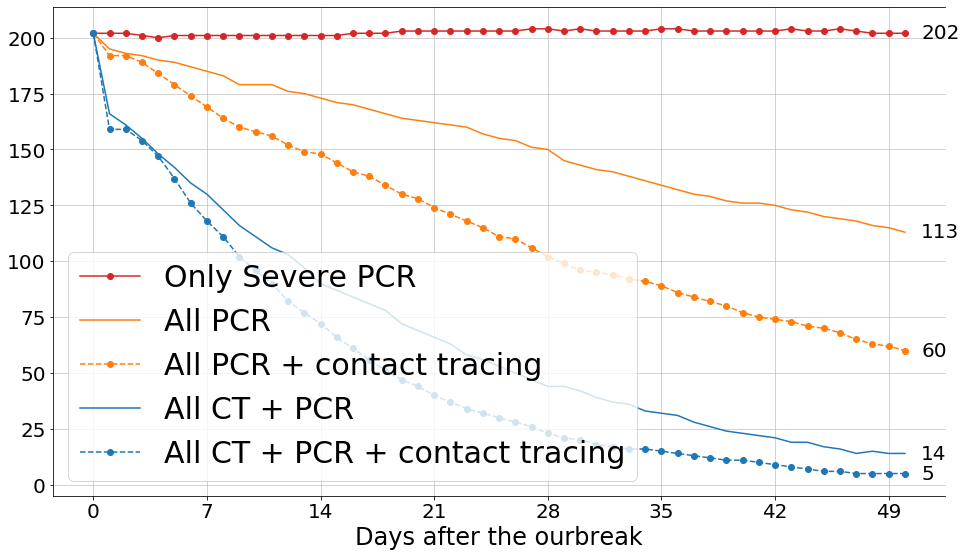

In [288]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(sc4.sum(axis=1).diff().iloc[20:].reset_index(drop=True), 'o-',c='C3', label='Only Severe PCR')

ax.plot(sc5.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C1', label='All PCR')
ax.plot(sc5a.sum(axis=1).diff().iloc[20:].reset_index(drop=True), 'o--',c='C1', label='All PCR + contact tracing')

ax.plot(sc6.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C0', label='All CT + PCR')
ax.plot(sc6a.sum(axis=1).diff().iloc[20:].reset_index(drop=True), 'o--',c='C0', label='All CT + PCR + contact tracing')

for sc in [sc4,sc5,sc5a,sc6,sc6a]:
    ax.annotate(int(sc.sum(axis=1).diff().values[-1]),
                xy=(len(sc)-20,sc.sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)

# ax.set_yscale('log')
ax.set_xlabel('Infected')
ax.set_xlabel('Days after the ourbreak', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=30)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[7]))

ax.grid(alpha=0.7)
# plt.tight_layout()
ax.spines['right'].set_visible(False)
# plt.savefig('figures/for paper/3 tesintg settings_3.png', dpi=600)

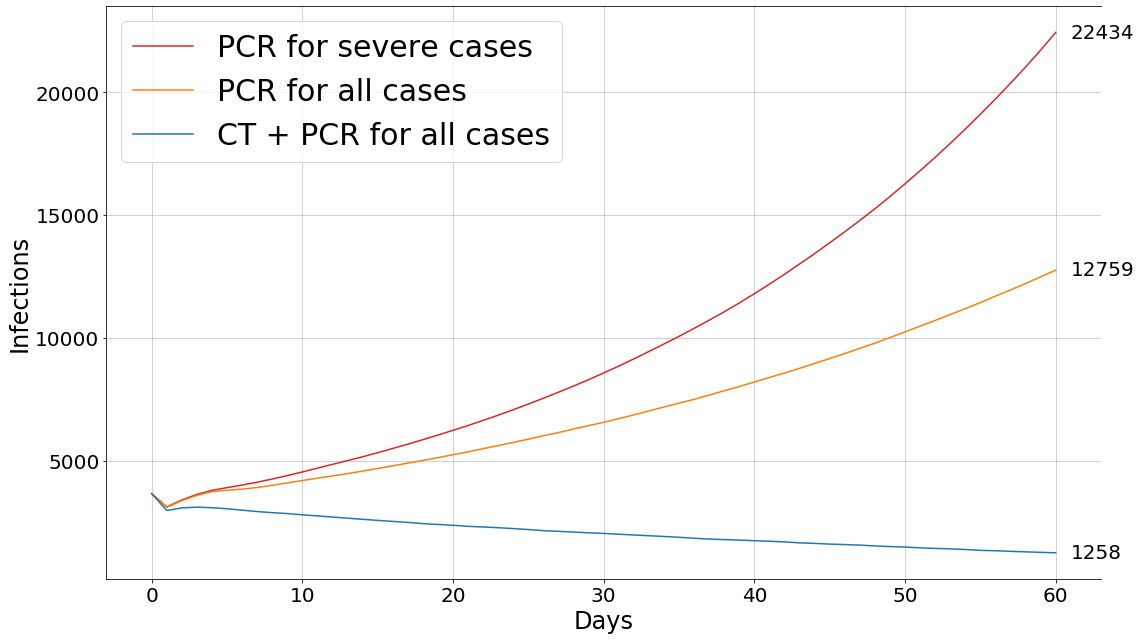

In [412]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(sc4.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C3', label='PCR for severe cases')
ax.plot(sc5.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C1', label='PCR for all cases')
ax.plot(sc6.sum(axis=1).diff().iloc[20:].reset_index(drop=True), '-',c='C0', label='CT + PCR for all cases')
# ax.plot(sc7.sum(axis=1).diff().iloc[20:].reset_index(drop=True), 'o--',c='C4', label='All CT + PCR + contact tracing')

for sc in [sc4,sc5,sc6]:
    ax.annotate(int(sc.sum(axis=1).diff().values[-1]),
                xy=(len(sc)-20,sc.sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)

# ax.set_yscale('log')
ax.set_ylabel('Infections', fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=30)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
plt.savefig('figures/for paper/3 tesintg settings_3.png', dpi=600)

In [34]:
total = []
detection = []

for _ in range(50):
    s = Simulation(1000)

    for day in range(50):
        s.step(Rt=1,
               D_s=4,
               D_m=4,
               TP_m=1,
               TP_ct=0)

    focus = pd.DataFrame(s.history.reshape(-1,4), columns=['Asymptomatic','Presymptomatic','Symptomatic','Isolated'])
    
    total.append(s.n_infected)
    detection.append(100*focus.iloc[-1,-1] / focus.iloc[-1].sum())

In [7]:
print(np.array(total).mean(), '\t',np.array(total).std())
print(np.array(detection).mean(), '\t',np.array(detection).std())
c = np.array(total) * (1 - np.array(detection) / 100)
print(c.mean(), '\t',c.std())

7989.96 	 102.90305340464879
16.22299005436685 	 0.4267159384723415
6693.78 	 95.00932375298754


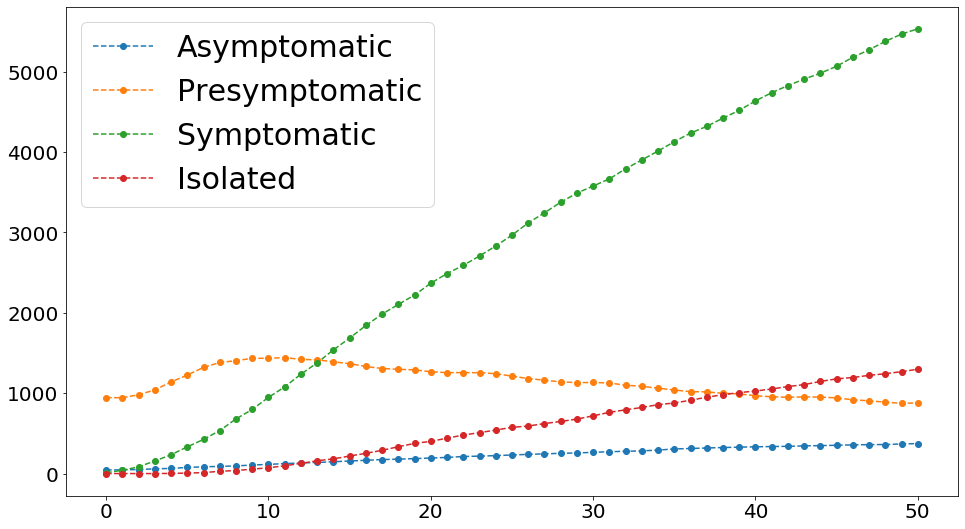

In [8]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

for i in list(focus):
    ax.plot(focus[i], 'o--', label=i)
# ax.plot(focus.iloc[:,:-1].sum(axis=1))

# ax.set_yscale('log')

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=30)

# Full ABM approach

In [945]:
# v0.1 working. Tracing is not efficient
p_severity = [0.05, 0.75, 0.2]
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = []
        self.test(d_s, d_m, tp_m)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m):
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
                
    
    def trace(self, trace_rate):
        if trace_rate == 0:
            return
        self.untraced = [i for i in self.cohort if i.type in [0,1,2]]
        for i in self.trace_cases:
            for j in self.untraced:
                if j.get_from == i and np.random.random() < trace_rate:
                    j.type = 4
            
            
            
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))
                
        
        


In [942]:
# v0.2 tracing better implemented, still not fast enough
p_severity = [0.05, 0.75, 0.2]
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = []
        self.test(d_s, d_m, tp_m)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m):
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
                
    
    def trace(self, trace_rate):
        if trace_rate == 0:
            return
        
        untraced = np.sort(np.append(np.append(world.asyptomatic, world.mild), world.severe))
        sub_patients = [i[1] for i in world.transition_chain if i[0] in world.trace_cases]
        for i in sub_patients:
            if self.cohort[i].type in [0,1,2]:
                self.cohort[i].type = 4
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.transition_chain = [(i.get_from, i.id) for i in world.cohort]
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))

In [1179]:
# v0.3 Working. add asymtomatic transimssion

p_severity = [0.05, 0.75, 0.2]
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.1 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # whether reset trace case
        
        self.test(d_s, d_m, tp_m)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m):
        # whether reset trace case
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    
    def trace(self, trace_rate):
        if trace_rate == 0:
            return
        
        untraced = np.sort(np.append(np.append(world.asyptomatic, world.mild), world.severe))
        sub_patients = [i[1] for i in world.transition_chain if i[0] in world.trace_cases]
        for i in sub_patients:
            if self.cohort[i].type in [0,1,2] and np.random.random()<trace_rate:
                self.cohort[i].type = 4
                
        # traced isolated case transfer to positive isolation once show symptom        
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
                
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.transition_chain = [(i.get_from, i.id) for i in world.cohort]
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))

In [2046]:
# v0.4 Adjust CT prescan procedure, add CT positive to traced

p_severity = [0.05, 0.75, 0.2] # asymptomatic/mild/severe ratio. 
s_pcr = 0.7 #sensitivy of PCR test
s_ct = 0.95 #sensitivity of CT test

"""
P_pcr: 
P_ct: 
D_s
D_m
TP_s
TP_m
TP_ct
"""
class World:
    def __init__(self, initial_infection):
        self.day = 0
        self.cohort = []
        for i in range(initial_infection):
            self.cohort.append(
                Patient(infection_day = self.day, my_id=i, get_from=-1, 
                        my_type=np.random.choice(3, p=p_severity)
                       )
            )
        self.history = pd.DataFrame()
        self.report_today = 0
        self.trace_cases = []
        self.update()
        
    
    def step(self, r, d_s=4, d_m=4, tp_m=0, trace_rate=0, ct=0):
        self.day += 1
        self.report_today = 0
        self.trace_cases = [] # whether reset trace case
        
        self.test(d_s, d_m, tp_m, ct)
        self.transmit(r)
        self.trace(trace_rate)
        self.update()
        
    def test(self, d_s, d_m, tp_m, ct):
        # whether reset trace case
        if ct> 0 :
            for i in np.append(self.mild, self.severe).astype(int):
                if self.cohort[i].onset_day + 1 <= self.day and np.random.random() < s_ct:
                    self.cohort[i].type = 4
                    self.report_today += 1
                    self.trace_cases.append(i)
        
        for i in self.severe:
            if self.cohort[i].onset_day + d_s <= self.day and np.random.random() < s_pcr:
                self.cohort[i].type = 3
                self.report_today += 1
                self.trace_cases.append(i)
                    
        if tp_m > 0:
            for i in self.mild:
                if self.cohort[i].onset_day + d_m <= self.day and np.random.random() < s_pcr:
                    self.cohort[i].type = 3
                    self.report_today += 1
                    self.trace_cases.append(i)
                

                

    def transmit(self, r):
        for i in self.cohort:
            if i.type == 1 or i.type == 2:
                i.patient_infect(self.day, r)
            if i.type == 0:
                i.patient_infect(self.day, r/10)
                
    
    def trace(self, trace_rate):
        # traced isolated case transfer to positive isolation once show symptom        
        for i in self.traced:
            if self.cohort[i].onset_day <= self.day:
                self.cohort[i].type = 3
                self.report_today += 1
        
        if trace_rate == 0:
            return
        
        untraced = np.sort(np.append(np.append(world.asyptomatic, world.mild), world.severe).astype(int))
        sub_patients = [i[1] for i in world.transition_chain if i[0] in world.trace_cases]
        for i in sub_patients:
            if self.cohort[i].type in [0,1,2] and np.random.random()<trace_rate:
                self.cohort[i].type = 4
        
    
    def update(self):
        self.infected = len(self.cohort)
        self.transition_chain = [(i.get_from, i.id) for i in world.cohort]
        self.asyptomatic = pd.Series(i.id for i in self.cohort if i.type == 0)
        self.mild = pd.Series(i.id for i in self.cohort if i.type == 1)
        self.severe = pd.Series(i.id for i in self.cohort if i.type == 2)
        self.isolated = pd.Series(i.id for i in self.cohort if i.type == 3)
        self.traced = pd.Series(i.id for i in self.cohort if i.type == 4)
        self.history.at[self.day, 'asyptomatic'] = len(self.asyptomatic)
        self.history.at[self.day, 'mild'] = len(self.mild)
        self.history.at[self.day, 'severe'] = len(self.severe)
        self.history.at[self.day, 'isolated'] = len(self.isolated)
        self.history.at[self.day, 'traced'] = len(self.traced)
        self.history.at[self.day, 'report'] = self.report_today
    
        self.history = self.history.astype(int)
    
            

class Patient:
    def __init__(self, infection_day, my_id, get_from, my_type):
        self.infection_day = infection_day
        self.onset_day = int(np.random.weibull(a=2.04) / 0.103) + self.infection_day
        self.id = my_id
        self.get_from = get_from
        self.type = my_type
        
    def patient_infect(self, current_day, r):
#         if np.random.random() < 0.01:
#             print(current_day)
#             print(self.infection_day)
#             print('------')
        tau = int(current_day - self.infection_day)
        if  tau <= 13 and self.type in [0,1,2]:
            if np.random.random() < r * beta_t[tau]:
                world.cohort.append(Patient(
                    infection_day = current_day, my_id = len(world.cohort), get_from = self.id,
                    my_type=np.random.choice(3, p=p_severity)
                ))

In [2047]:
# Initialize world and run 20 days without tesing
world = World(1000)

for i in range(20):
    world.step(r=1.07,
              d_s=4,
              d_m=4,
              tp_m=0,
              trace_rate=0)

import copy
initial = copy.deepcopy(world)

In [2048]:
t = []

In [2049]:
# Different testing strategies from Day 20
for _ in range(10):
    r_star = 1.07
    
    # d_s, d_m, t_m, tracing_rate, CT
    parameter_matrix = [
        [r_star, 4, 4, 0, 0, 0],
        [r_star, 4, 4, 1, 0, 0],
        [r_star, 4, 4, 1, 0.5, 0],
        [r_star, 4, 4, 1, 0, 1],
        [r_star, 4, 4, 1, 0.5, 1],
    ]

    result = []
    for i in range(len(parameter_matrix)):    
        world = copy.deepcopy(initial)
        for day in range(60):
            world.step(r=parameter_matrix[i][0],
                   d_s=parameter_matrix[i][1],
                   d_m=parameter_matrix[i][2],
                   tp_m=parameter_matrix[i][3],
                   trace_rate=parameter_matrix[i][4],
                   ct=parameter_matrix[i][5],
                    )
#         print(i)
        result.append(world.history)

    # history1, history2, history2a, history3, history3a = result
    t.append(result)
    print(len(t))

1
2
3
4
5


KeyboardInterrupt: 

In [2041]:


scale = 8.264462809917354
count = len(t)

history1 = (reduce(do_sum, [t[i][0] for i in range(count)])/count * scale).astype(int)
history2 = (reduce(do_sum, [t[i][1] for i in range(count)])/count * scale).astype(int)
history2a = (reduce(do_sum, [t[i][2] for i in range(count)])/count * scale).astype(int)
history3 = (reduce(do_sum, [t[i][3] for i in range(count)])/count * scale).astype(int)
history3a = (reduce(do_sum, [t[i][4] for i in range(count)])/count * scale).astype(int)

In [2042]:
history1.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True)
2000 / 242

0     2000.0
1     1895.0
2     1912.0
3     1902.0
4     1918.0
       ...  
56    2103.0
57    2173.0
58    2085.0
59    2166.0
60    2195.0
Length: 61, dtype: float64

In [1230]:
# world = copy.deepcopy(initial)

# for day in range(60):
#     world.step(r=1.07,
#            d_s=4,
#            d_m=4,
#            tp_m=1,
#            trace_rate=0,
#            ct=1,)
            
# history3 = world.history

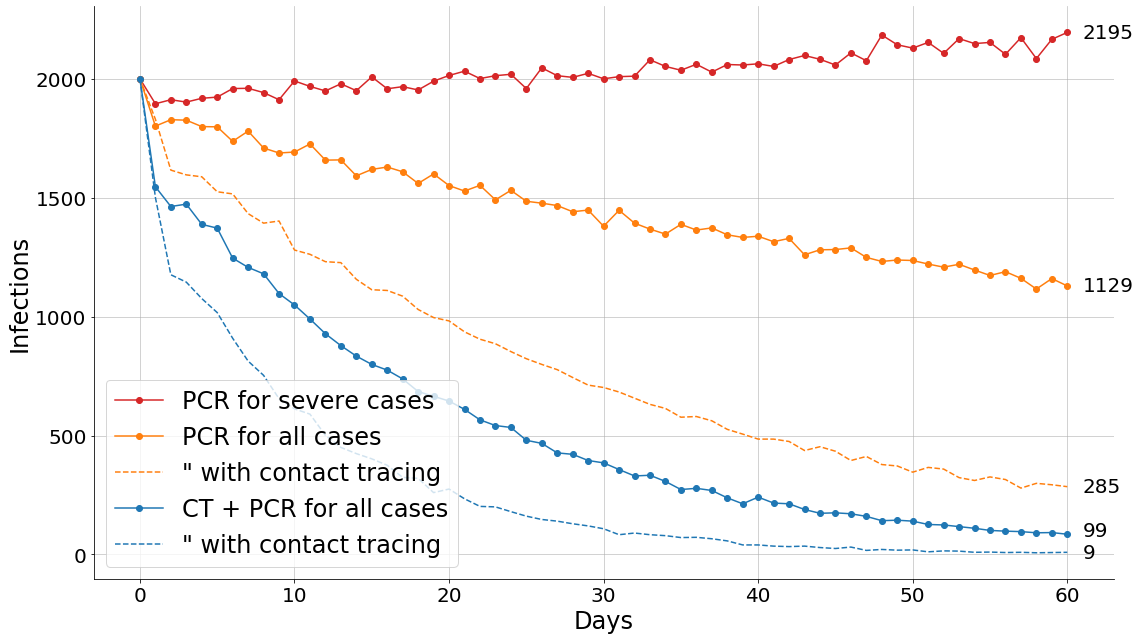

In [2045]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C3', label='PCR for severe cases')
ax.plot(history2.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
ax.plot(history2a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')
ax.plot(history3.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C0', label='CT + PCR for all cases')
ax.plot(history3a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for i in [history1, history2, 
          history2a, history3a
         ]:
    ax.annotate(int(i.iloc[:,:5].sum(axis=1).diff().values[-1]),
                xy=(len(i)-20,i.iloc[:,:5].sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)
i = history3.copy()
ax.annotate(int(99),
                xy=(len(i)-20,99),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/for paper/Simulation_result_sct85b.png', dpi=600)

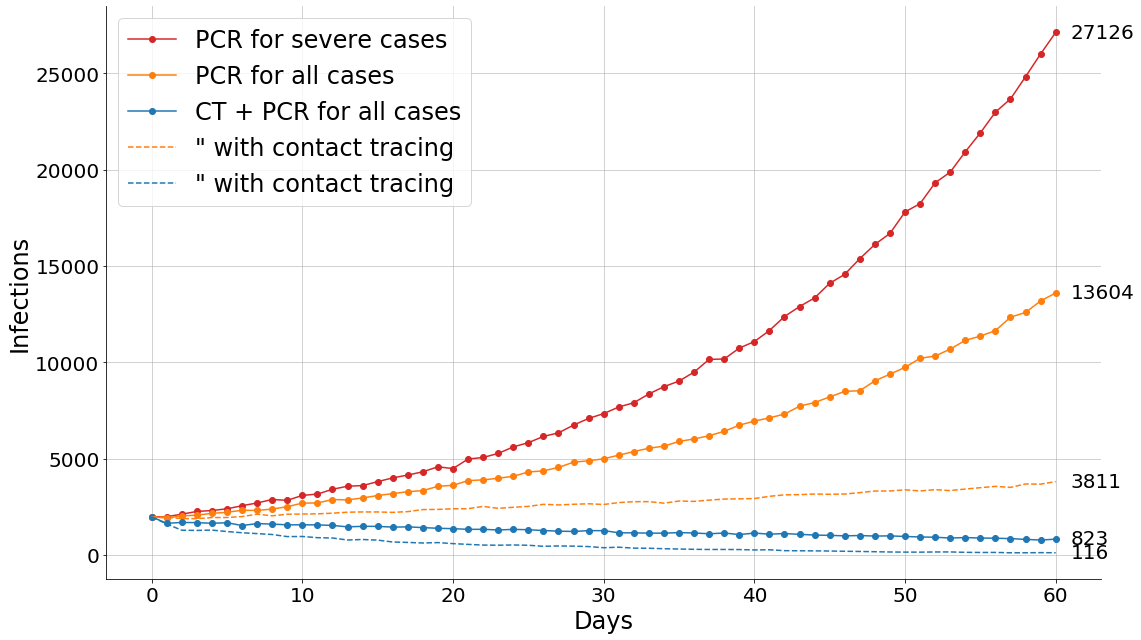

In [1367]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C3', label='PCR for severe cases')
ax.plot(history2.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
ax.plot(history3.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C0', label='CT + PCR for all cases')
ax.plot(history2a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')
ax.plot(history3a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for i in [history1, history2, history3, 
          history2a, history3a
         ]:
    ax.annotate(int(i.iloc[:,:5].sum(axis=1).diff().values[-1]),
                xy=(len(i)-20,i.iloc[:,:5].sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)
# i = history3a.copy()
# ax.annotate(int(i.iloc[:,:5].sum(axis=1).diff().values[-1]),
#                 xy=(len(i)-20,i.iloc[:,:5].sum(axis=1).diff().values[-1]-60),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('figures/for paper/Simulation_result2.png', dpi=600)

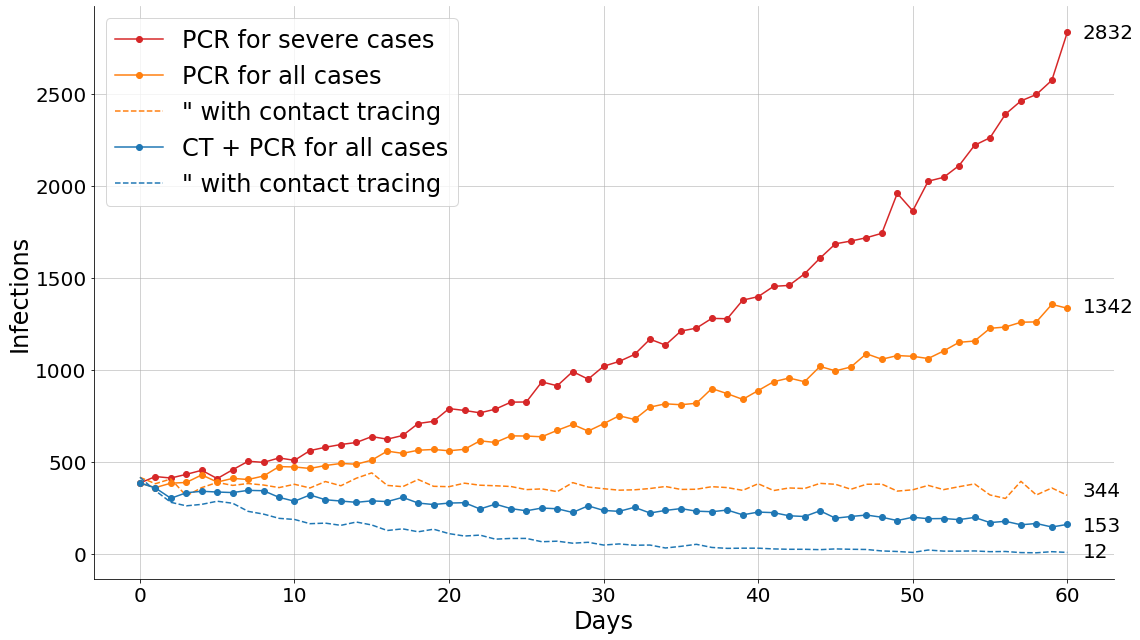

In [846]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C3', label='PCR for severe cases')
ax.plot(history2.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
ax.plot(history2a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')


ax.plot(history3.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C0', label='CT + PCR for all cases')
ax.plot(history3a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for i in [history1, history2, history3, history2a, history3a]:
    ax.annotate(int(i.iloc[:,:5].sum(axis=1).diff().values[-1]),
                xy=(len(i)-20,i.iloc[:,:5].sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('figures/for paper/Simulation_result2.png', dpi=600)

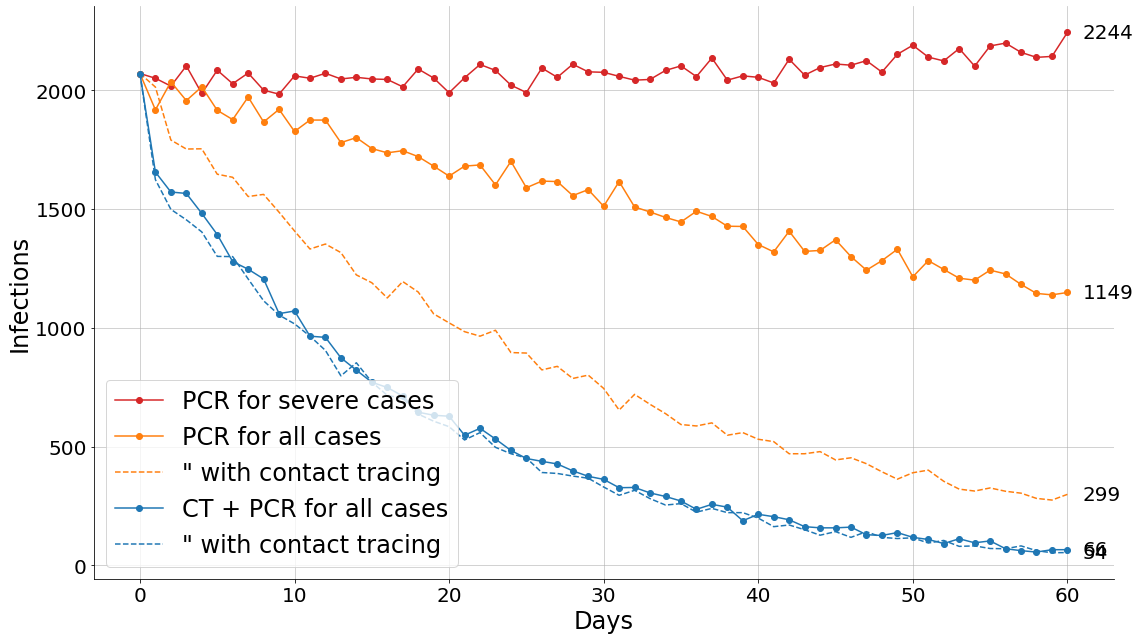

In [1242]:
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(16,9))

ax.plot(history1.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C3', label='PCR for severe cases')
ax.plot(history2.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C1', label='PCR for all cases')
ax.plot(history2a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C1', label='\" with contact tracing')


ax.plot(history3.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), 'o-',c='C0', label='CT + PCR for all cases')
ax.plot(history3a.iloc[:,:5].sum(axis=1).diff()[20:].reset_index(drop=True), '--',c='C0', label='\" with contact tracing')

for i in [history1, history2, history3,history2a, history3a]:
    ax.annotate(int(i.iloc[:,:5].sum(axis=1).diff().values[-1]),
                xy=(len(i)-20,i.iloc[:,:5].sum(axis=1).diff().values[-1]),va='center',ha='left',fontsize=20)
    

ax.set_ylabel('Infections',fontsize=24)
ax.set_xlabel('Days', fontsize=24)

ax.tick_params(labelsize=20)
ax.legend(loc=0, fontsize=24)

ax.xaxis.set_major_locator(plt.MaxNLocator(steps=[10]))

ax.grid(alpha=0.7)
plt.tight_layout()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.savefig('figures/for paper/Simulation_result_2.png', dpi=600)

In [864]:
history3a.iloc[:,:5].sum(axis=1).diff().values[-1]

3.0